In [1]:
%matplotlib notebook
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntoolstest as nt
import numpy as np
import h5py
import PIL
from scipy.io import loadmat

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [3]:
def rotate_image(image):
    return image.rotate(-90, expand=True)

class NYUDataset(Dataset):

    def __init__(self, filename, type="training", image_size=(256, 256)):
        self.f = h5py.File(filename, 'r')
        self.image_size = image_size
        self.images_data = self.f['images'][0:1449]
        self.depths_data = self.f['depths'][0:1449]

        if type == "training":
            self.images = self.images_data[0:700]
            self.depths = self.depths_data[0:700]
        elif type == "val":
            self.images = self.images_data[700:1000]
            self.depths = self.depths_data[700:1000]
        elif type == "test":
            self.images = self.images_data[1000:]
            self.depths = self.depths_data[1000:]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        color_map = self.images[idx]
        color_map = np.moveaxis(color_map, 0, -1)
        color_image = Image.fromarray(color_map, mode='RGB')
        color_image = rotate_image(color_image)

        depth_map = self.depths[idx]
        depth_image = Image.fromarray(depth_map, mode='F')
        depth_image = rotate_image(depth_image)
        
        transform = tv.transforms.Compose([
            tv.transforms.CenterCrop(self.image_size),
            tv.transforms.RandomRotation(2, resample=PIL.Image.BILINEAR),
            tv.transforms.ColorJitter(hue=.05, saturation=.05),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])  
        
        transform2 = tv.transforms.Compose([
            tv.transforms.CenterCrop(self.image_size),
            tv.transforms.ToTensor()])
        
        color_image = transform(color_image)
        depth_image = transform2(depth_image)

        return color_image, depth_image

In [4]:
fn = '/datasets/ee285f-public/nyu_depth_v2_labeled.mat'
px, py = 256, 256
train_set = NYUDataset(fn, type = "training", image_size=(px, py))
val_set = NYUDataset(fn, type = "val", image_size=(px, py))
test_set = NYUDataset(fn, type = "test", image_size=(px, py))

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off') 
    return h

In [6]:
def mydepthshow(image, ax=plt):
    image = image.to('cpu').numpy()
    lx, ly = image.shape[1], image.shape[2]
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    h = ax.scatter(x,y,c=np.flip(image[0,:,:], 0))
    ax.axis('off') 
    return h

In [7]:
def tdloss(y, d, depth=1.25):
    d = F.max_pool2d(F.max_pool2d(d,kernel_size = 2),kernel_size=2)


    valid_pixels = torch.sum(torch.abs(y.to('cpu')-d.to('cpu'))<depth)
    total_pixels = torch.from_numpy(np.array([px*py], dtype=np.float)).float()

    return valid_pixels/total_pixels

In [8]:
def norm12lossnhuber(y, d):
    lam = 0.5
    d = F.max_pool2d(F.max_pool2d(d,kernel_size = 2),kernel_size=2)
    y = y.to('cpu')
    d = d.to('cpu')
    res = torch.log10(torch.abs(y-d))
    val1 = (1./d.numel())*torch.norm(res, p=2)**2
    val2 = (lam/(d.numel()**2))*(torch.sum(res)**2)
    val = val1+val2
    huber = nn.SmoothL1Loss()

    return val, huber.forward(y, d)

In [9]:
class NNRegressor(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.lam = 0.5
        self.huber = nn.SmoothL1Loss()
        
    def norm12loss(self, y, d):
#         d = F.max_pool2d(F.max_pool2d(d, kernel_size=2, return_indices=False), \
#                          kernel_size=2, return_indices=False)
#         print (y.shape, d.shape)
        res = torch.log10(torch.abs(y-d))
        val1 = (1./d.numel())*torch.norm(res, p=2)**2
        val2 = (self.lam/(d.numel()**2))*(torch.sum(res)**2)
        val = val1+val2
#         print (val.shape)
        return val

    def criterion(self, y, d):
        d = F.max_pool2d(F.max_pool2d(d, kernel_size=2, return_indices=False), \
                         kernel_size=2, return_indices=False)
        return self.norm12loss(y,d) +self.huber(y,d)

In [10]:
class DepthStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(DepthStatsManager, self).__init__()
        
    def init(self):
        super(DepthStatsManager, self).init()
        self.proloss = 0
        self.mseloss = 0
        
    def accumulate(self, loss, x, y, d): 
        d = F.max_pool2d(F.max_pool2d(d,kernel_size = 2),kernel_size=2)
        super(DepthStatsManager, self).accumulate(loss, x, y, d) 
        self.proloss+=loss
        self.mseloss += torch.dist(y,d,p=2)
         
    def summarize(self):
        loss = super(DepthStatsManager, self).summarize() 
        tloss = self.proloss/self.number_update
        loss = self.mseloss/self.number_update
        return {'loss': loss,'huber': tloss}

In [11]:
class DDnCNN2(NNRegressor):
    def __init__(self, n_pixels):
        super(DDnCNN2, self).__init__()
        self.n_pixels = n_pixels/4
        self.cnet = nn.ModuleList()
        self.fnet = nn.ModuleList()
        self.bn = nn.ModuleList()
        
        self.bn.append(nn.BatchNorm2d(16,16))
        self.bn.append(nn.BatchNorm2d(16,16))
        self.cnet.append(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, padding=5)) #stride=4
        self.cnet.append(nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, padding=2))
        self.cnet.append(nn.Conv2d(in_channels=256, out_channels=1, kernel_size=5, padding=2))

        self.fnet.append(nn.Conv2d(in_channels=3, out_channels=1, kernel_size=5, padding=2))
        self.fnet.append(nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1))

    def num_flat_features(self, x):
        return torch.numel(x)
    
    def forward(self, x):
#         print ('In forward',x.shape)
        sz0 = x.shape
        coarse, idx1= F.max_pool2d(F.relu(self.cnet[0](x)), kernel_size=2, return_indices=True)
        sz1 = coarse.shape
        coarse, idx2 = F.max_pool2d(F.relu(self.cnet[1](coarse)), kernel_size=2, return_indices=True)
#         coarse = F.relu(self.cnet[0](x))
#         coarse = F.relu(self.cnet[1](coarse))
#         print (coarse.shape)
        coarse = F.relu(self.cnet[2](coarse))
        
#         coarse = F.max_unpool2d(coarse, indices=idx2, kernel_size=2,output_size=sz1)
#         coarse = F.max_unpool2d(coarse, indices=idx1, kernel_size=2,output_size=sz0)
#         print (coarse.shape)
        fine = F.max_pool2d(F.max_pool2d(F.relu(self.fnet[0](x)), kernel_size=2, return_indices=False), \
                         kernel_size=2, return_indices=False)
#         fine = F.relu(self.fnet[0](x))
        y = (1./np.sqrt(2))*fine.add(coarse)

        return y
    
    def num_flat_features(self, x):
        return torch.numel(x)

In [12]:
def plot(exp, fig, axes, color, visu_rate=1):
    if exp.epoch % visu_rate != 0: 
        return
    with torch.no_grad():
        pred_depth = exp.net(color[np.newaxis].to(exp.net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(color, ax=axes[0][0]) 
    mydepthshow(pred_depth, ax=axes[0][1]) 

    axes[0][0].set_title('Color image') 
    axes[0][1].set_title('Predicted depth image') 
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training") 
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="validation") 
    axes[1][1].plot([exp.history[k][0]['huber'] for k in range(exp.epoch)],
                 label="training")
    axes[1][1].plot([exp.history[k][1]['huber'] for k in range(exp.epoch)],
                 label="validation")
    
    axes[1][0].legend()
    axes[1][1].legend()
    axes[1][0].set_xlabel('Epoch') 
    axes[1][0].set_ylabel('MSE Loss')
    axes[1][1].set_xlabel('Epoch') 
    axes[1][1].set_ylabel('Scale Invariant+Huber Loss')

    plt.tight_layout()
    fig.canvas.draw()

In [13]:
lr = 1e-4
net = DDnCNN2(n_pixels=px*py)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DepthStatsManager()
torch.optim.lr_scheduler.ExponentialLR(adam, gamma=1e-3)
exp2 = nt.Experiment(net, train_set, val_set=val_set, optimizer = adam, stats_manager = 
                     stats_manager, output_dir="n3-f3-1", 
                     batch_size = 1, perform_validation_during_training=True)

<IPython.core.display.Javascript object>


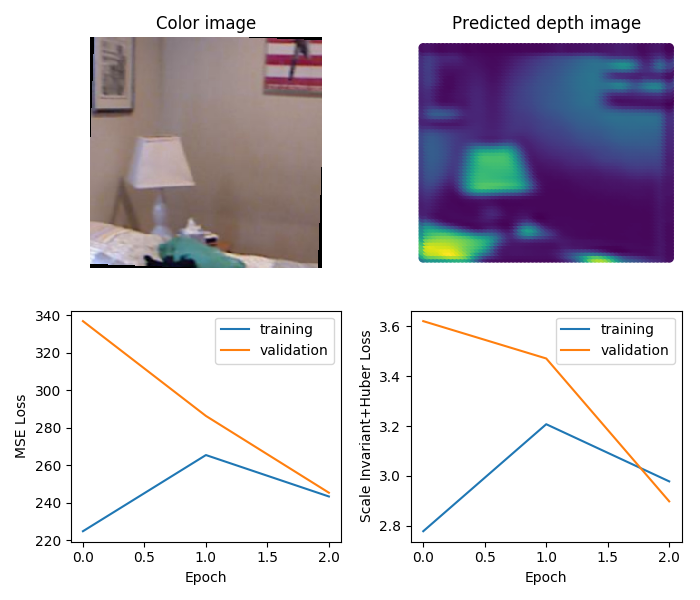

Start/Continue training from epoch 0
Epoch 1 (Time: 27.95s)
Epoch 2 (Time: 26.84s)
Epoch 3 (Time: 27.25s)
Epoch 4 (Time: 26.91s)


FileNotFoundError: [Errno 2] No such file or directory: 'n3-f3-1/checkpoint.pth.tar'

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp2.run(num_epochs=10, plot=lambda exp: plot(exp, fig=fig, axes=axes, color=test_set[5][0]))